In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'msft' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1, 3, or 5 days ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'a': '11/15/1999'# Updated 1/5/21 1D, 3D, 5D ahead
               , 'aapl':'12/12/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'adbe': '08/11/1986' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'goog': '08/16/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'intc': '03/16/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'ma': '05/21/2006' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'mdb': '10/15/2017' # Updated 1/6/21 1D, 3D, 5D ahead *
               , 'msft': '03/10/1986' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'nio': '09/10/2018' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'qqq': '03/08/1999' # Updated 1/6/21 1D, 3D, 5D ahead *
               , 'tsla': '06/29/2010' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'v': '03/16/2008' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vbr': '01/26/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'viov': '09/06/2010' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'xlk': '12/21/1998' # Updated 1/6/21 1D, 3D, 5D ahead *
              }

In [4]:
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-22,225.630005,221.850006,222.690002,223.940002,22612200.0,223.940002,-0.005613,0.017039,0.006065,0.011778,0.009054,-1
2020-12-23,223.559998,220.800003,223.110001,221.020004,18699600.0,221.020004,0.009368,0.012500,-0.013039,0.011651,0.001636,1
2020-12-24,223.610001,221.199997,221.419998,222.750000,10550600.0,222.750000,-0.006007,0.010895,0.007827,0.011937,0.003074,1
2020-12-28,226.029999,223.020004,224.449997,224.960007,17933500.0,224.960007,-0.002272,0.013497,0.009921,0.011536,0.005815,-1
2020-12-29,227.179993,223.580002,226.309998,224.149994,17403200.0,224.149994,0.009544,0.016102,-0.003601,0.009607,0.001435,-1
2020-12-30,225.630005,221.470001,225.229996,221.679993,20272300.0,221.679993,0.015762,0.018784,-0.011019,0.010541,-0.001982,1
2020-12-31,223.000000,219.679993,221.699997,222.419998,20926900.0,222.419998,-0.003248,0.015113,0.003338,0.008615,0.001293,-1
2021-01-04,223.000000,214.809998,222.529999,217.690002,37130100.0,217.690002,0.021750,0.038127,-0.021266,0.012184,-0.004525,1
2021-01-05,218.520004,215.699997,217.259995,217.899994,23823000.0,217.899994,-0.002946,0.013074,0.000965,0.009990,-0.006317,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

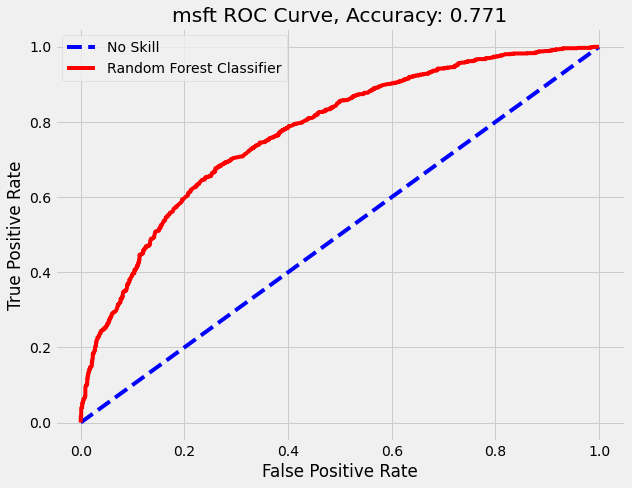

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

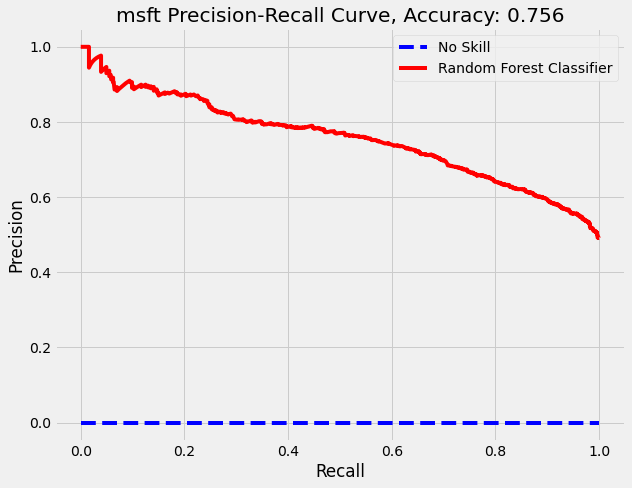

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

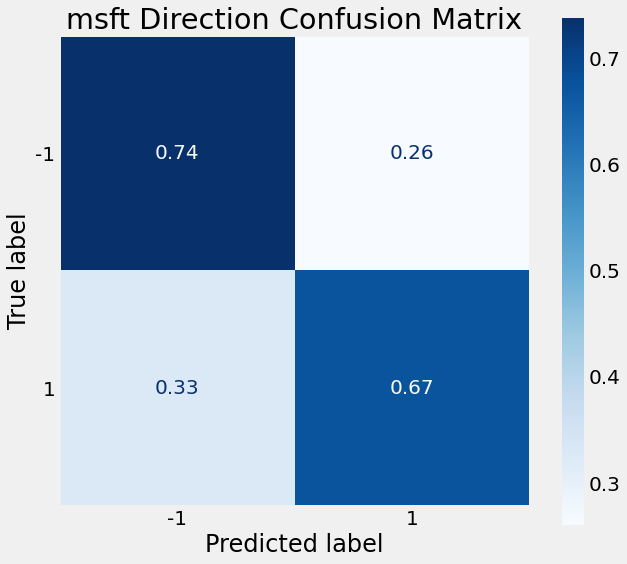

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.7134070110808993'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          2.164900e+02
Low           2.119400e+02
Open          2.121700e+02
Close         2.122500e+02
Volume        3.588340e+07
Adj Close     2.122500e+02
oc           -3.770648e-04
hl            2.146835e-02
adj          -2.592930e-02
5stdev_adj    1.300745e-02
5sma_adj     -1.078239e-02
direction    -1.000000e+00
Name: 2021-01-06 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
last

oc            0.027273
hl            0.066667
5stdev_adj    0.018935
5sma_adj     -0.015879
Name: 1986-03-21 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    8772.000000
mean        0.001159
std         0.021492
min        -0.301158
25%        -0.009217
50%         0.000356
75%         0.011328
max         0.195652
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name} {days_ahead} day(s) ahead')
else:
    print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

Buy msft 1 day(s) ahead


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-30,225.630005,221.470001,225.229996,221.679993,20272300.0,221.679993,0.015762,0.018784,-0.011019,0.010541,-0.001982,1,1,0.003338
2020-12-31,223.000000,219.679993,221.699997,222.419998,20926900.0,222.419998,-0.003248,0.015113,0.003338,0.008615,0.001293,-1,-1,0.021266
2021-01-04,223.000000,214.809998,222.529999,217.690002,37130100.0,217.690002,0.021750,0.038127,-0.021266,0.012184,-0.004525,1,1,0.000965
2021-01-05,218.520004,215.699997,217.259995,217.899994,23823000.0,217.899994,-0.002946,0.013074,0.000965,0.009990,-0.006317,-1,-1,0.025929
2021-01-06,216.490005,211.940002,212.169998,212.250000,35883400.0,212.250000,-0.000377,0.021468,-0.025929,0.013007,-0.010782,-1,-1,-0.000356


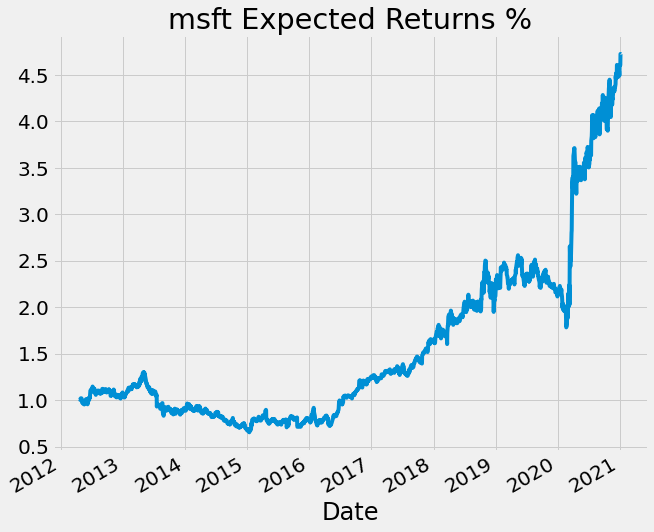

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

7.085769551489203

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

51.95906432748538

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

In [22]:
# Train all...this takes a while, 10.5+ hours!
# stocks = [x for x in start_dates]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)
#
#
# Train desired stocks...takes less time
# stocks = ['mdb', 'qqq', 'xlk']
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)

### Recording Results

In [31]:
[x for x in start_dates]

['a',
 'aapl',
 'acy',
 'adbe',
 'amd',
 'baba',
 'bac',
 'crm',
 'esgv',
 'goog',
 'ibm',
 'idex',
 'intc',
 'iyw',
 'ma',
 'mdb',
 'msft',
 'nio',
 'nvda',
 'pypl',
 'qqq',
 'tsla',
 'v',
 'vbiv',
 'vbr',
 'viov',
 'vgt',
 'xlk']

Buy ma 1 day(s) ahead
Model Returns (x 100 for %): 2.722
Stock Returns (x 100 for %): 12.5587


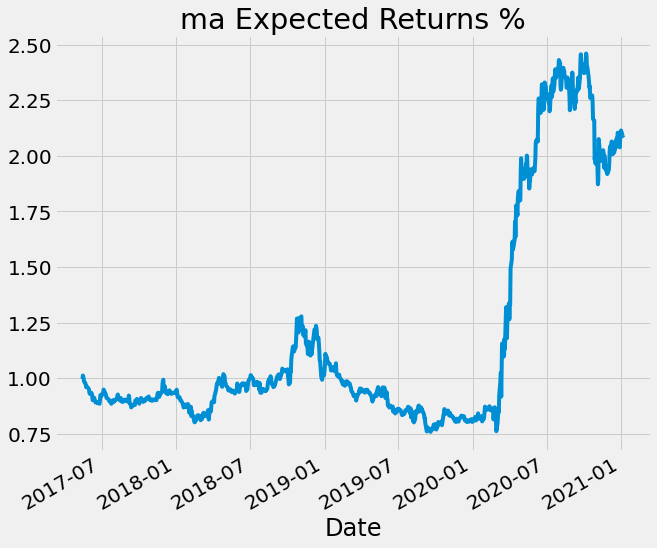

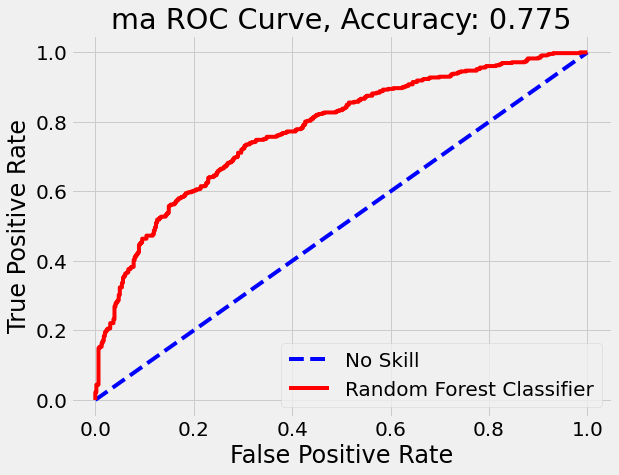

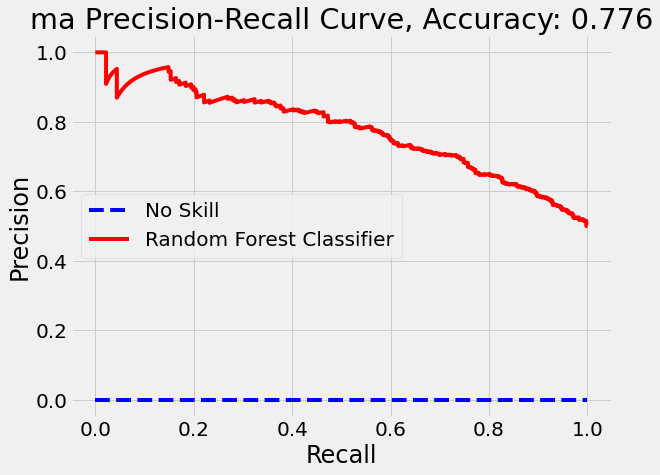

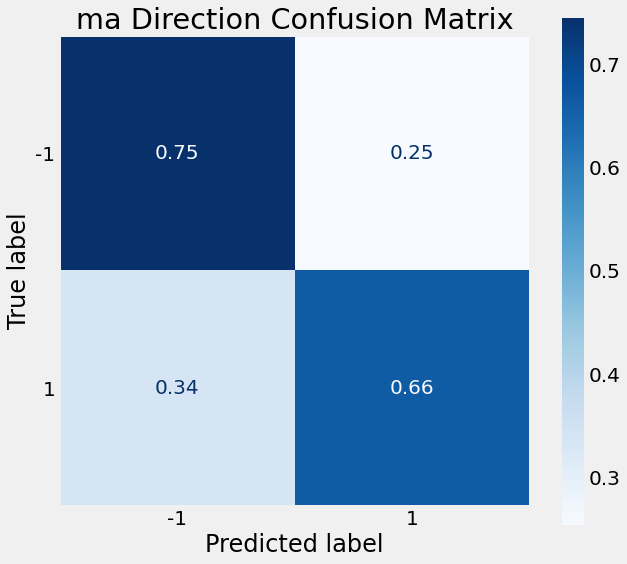

In [44]:
stock_name = 'ma'
a.all_func(stock_name
           , start_dates[stock_name]
           , days_ahead = 1
           , model_name = model_name
           , days_back = 1
          )